In [1]:
from IPython.display import clear_output
!git clone https://github.com/jroakes/querycat.git
!pip install -r querycat/requirements_colab.txt

clear_output()
print('All loaded.')


All loaded.


## Import QueryCat

In [2]:
import querycat

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Load Datset of comparative data from Google Search Console

In [3]:
df = querycat.pd.read_csv('querycat/data/loco_compare.csv')
df.head(20)

,Query,Last 28 days Clicks,Previous 28 days Clicks,Last 28 days Impressions,Previous 28 days Impressions,Last 28 days CTR,Previous 28 days CTR,Last 28 days Position,Previous 28 days Position
0,google analytics export more than 5000 rows,30,20,48,29,62.50%,68.97%,1.00,1.00
1,adapt partners,28,20,55,51,50.91%,39.22%,1.22,1.22
2,export more than 5000 rows google analytics,27,11,49,20,55.10%,55%,1.02,1.00
3,locomotive agency,24,4,383,130,6.27%,3.08%,3.80,5.52
4,locomotive agency apex,21,0,35,6,60%,0%,4.17,5.00
5,locomotive agency apex nc,20,10,35,22,57.14%,45.45%,3.57,4.05
6,locomotive seo,16,0,20,0,80%,0%,1.00,0.00
7,google analytics export all rows,13,12,39,25,33.33%,48%,2.36,2.40
8,google analytics export more than 5000,12,15,134,139,8.96%,10.79%,1.00,1.00
9,how to export more than 5000 rows in google an...,9,10,33,30,27.27%,33.33%,2.12,2.20


##  Categorize the queries

The `querycat.Categorize` function, takes the following arguments.

* **Position 1**: A Pandas Dataframe that includes at least a column of search queries.
* **col**: The name of the query column from the DataFrame
* **alg**: Either `apriori` (Apriori Algorithm), or `fpgrowth` (FP Growth Algorithm)
* **min_support**: The number of times the subset terms should be found in the dataset to be included.
* **min_probablity**: FP Growth only. Finds patterns of associated terms above this minimum probability 0-1 (float)
* **min_lift**: Apriori only. Finds patterns of associated terms. <1 less probable, >1 more probable  (float)

After it runs, it will print the number of categories found, as well as the frequencies of queries in each category.

In [5]:
catz = querycat.Categorize(df, 'Query', min_support=10,  alg='apriori')
catz.counts.head(20)

Converting to transactions.
Normalizing the keyword corpus.
Total queries: 1364
Total unique queries: 987
Total transactions: 986
Running Apriori
Making Categories
Total Categories: 101


,category
seo,252
##other##,63
seo technical,52
google business,52
google analytics,48
google analytics data,43
google analytics export,42
google,36
agency,36
google search,35


## Show original data
Below we print the original DataFrame with categories added.

This can be saved to CSV using `catz.df.to_csv('filename.csv', index=False)` to save and use in Excel.

In [6]:
catz.df.head(20)

,Query,Last 28 days Clicks,Previous 28 days Clicks,Last 28 days Impressions,Previous 28 days Impressions,Last 28 days CTR,Previous 28 days CTR,Last 28 days Position,Previous 28 days Position,match_queries,category
0,google analytics export more than 5000 rows,30,20,48,29,62.50%,68.97%,1.00,1.00,analytics export google row,google analytics export
1,adapt partners,28,20,55,51,50.91%,39.22%,1.22,1.22,adapt partner,partner
2,export more than 5000 rows google analytics,27,11,49,20,55.10%,55%,1.02,1.00,analytics export google row,google analytics export
3,locomotive agency,24,4,383,130,6.27%,3.08%,3.80,5.52,agency locomotive,locomotive
4,locomotive agency apex,21,0,35,6,60%,0%,4.17,5.00,agency apex locomotive,locomotive
5,locomotive agency apex nc,20,10,35,22,57.14%,45.45%,3.57,4.05,agency apex locomotive nc,locomotive
6,locomotive seo,16,0,20,0,80%,0%,1.00,0.00,locomotive seo,seo
7,google analytics export all rows,13,12,39,25,33.33%,48%,2.36,2.40,analytics export google row,google analytics export
8,google analytics export more than 5000,12,15,134,139,8.96%,10.79%,1.00,1.00,analytics export google,google analytics export
9,how to export more than 5000 rows in google an...,9,10,33,30,27.27%,33.33%,2.12,2.20,analytics export google row,google analytics export


## Make use of original data

This cell will aggregate data from your original CSV to produce an updated DataFrame that has current and previous period data consolidated by category.  We also include a `diff` column that shows the period change.

In [7]:
df = catz.df
df.head()

# Goup by category and aggregate the other metrics
df = df.groupby(['category'], as_index=False).agg({'Query':'count', 'Last 28 days Clicks':'sum', 'Previous 28 days Clicks': 'sum' })

# Create a diff column
df['Diff'] = df['Last 28 days Clicks'] - df['Previous 28 days Clicks']

# Rename the columns
df.columns = ['category', 'count of queries', 'current', 'prior', 'diff']

# Sort by the `diff` columnn
df.sort_values(by='diff', ascending=False, inplace=True)

df.head(10)

,category,count of queries,current,prior,diff
52,locomotive,16,65,14,51
41,google analytics export,42,112,76,36
70,seo,252,25,1,24
57,partner,6,28,20,8
79,seo technical,52,5,0,5
62,python google analytics,16,2,0,2
24,console google search,17,2,0,2
26,content,3,1,0,1
49,link building,30,1,0,1
72,seo best,8,1,0,1


## BERT

By default, we use the `distilbert-base-uncased` model from the [Huggingface Transformers repo](https://github.com/huggingface/transformers).  
This can be edited in the `querycat/config.py` file.

The BERTSim class has a few functions that are useful:

* **read_df**: Reads a dataframe where the `term_col` and `diff_col` are specified as named parameters.
* **get_similar_df**: After running `read_df`, you can provide a term as a parameter to get the top matching categories, by cosine similarity.
* **diff_plot**: After running `read_df`, plots the output in 2d vector space, using either `umap`, `pca`, or `tsne` as vector reduction strategies. 

In [8]:
bsim = querycat.BERTSim()

### Read DataFrame into Class

In [0]:
bsim.read_df(df, term_col = 'category', diff_col = 'diff')

### Print similar categories to a given term.

In [11]:
df_sim = bsim.get_similar_df('train')
df_sim.sort_values(by='sim', ascending=False, inplace=True)
df_sim.head()

,terms,sim
0,locomotive,0.846860
58,analytics data,0.693261
65,google data,0.678765
76,google analytics data,0.652805
11,post,0.649012


### Plot Categories

This cell plots the categories in 2D space, with reduction from BERT summed 768 dimension vectors to 2 dimension, based on the given reduction strategy.  Green is increase PoP, red is descrease.  Size is the magnitude of the change.

Reduction strategies available are `umap`, `tsne`, and `pca`



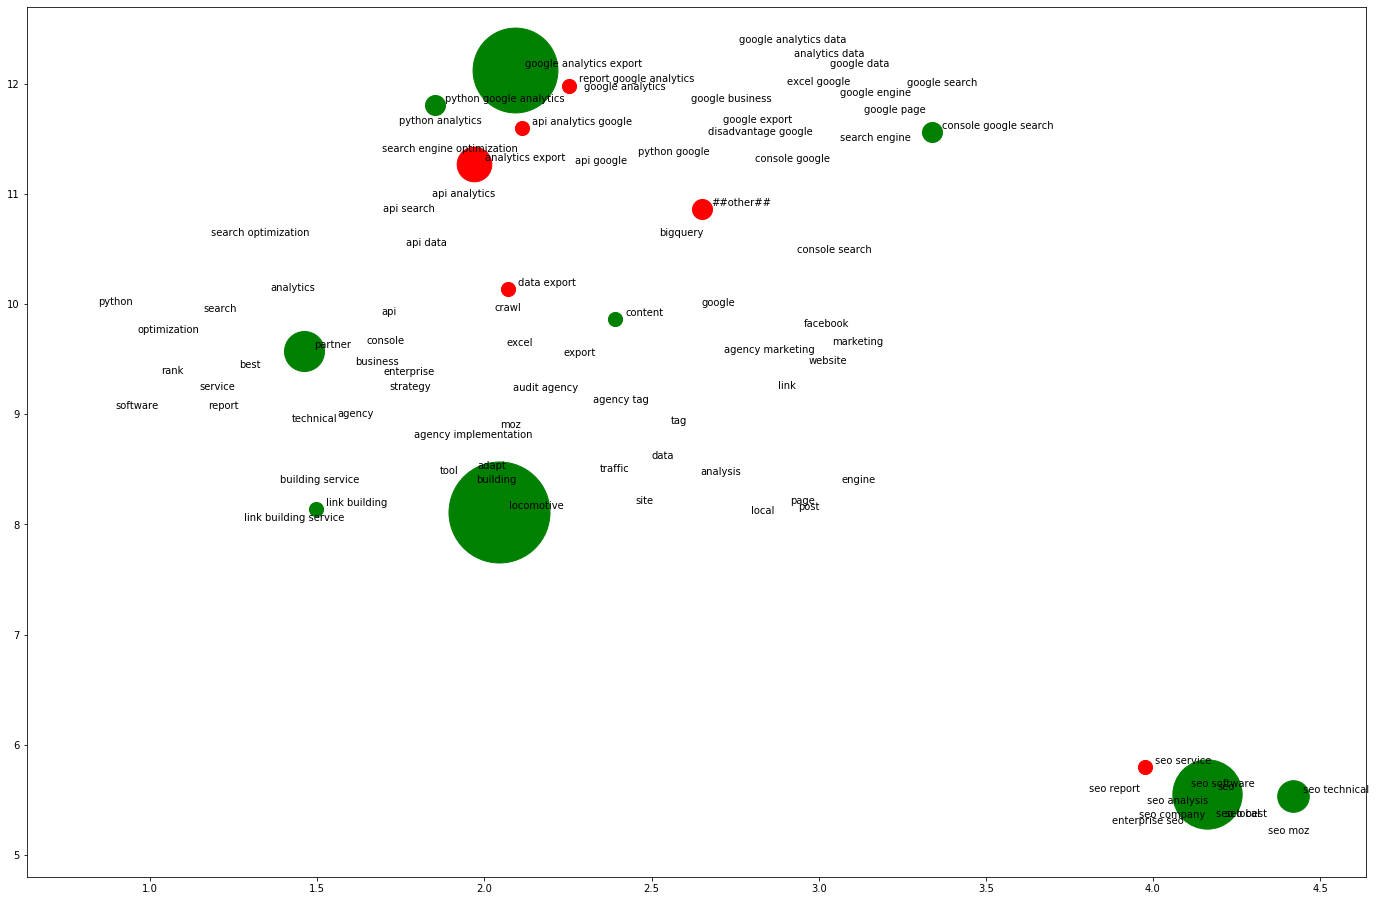

In [16]:
bsim.diff_plot(reduction='umap')